### 安裝相關套件

In [ ]:
!pip install -r requirements.txt

### import 套件

In [2]:
import configparser
import os
import torch
from dataset import LinkPredictionDataset, sample_friend_pairs
from model import Pipeline
from utils import compute_rank_error
from tqdm import tqdm
from main import RandomWalkWithRestart

### Load the setting file
read the setting file

In [3]:
# read from setting file
configs = configparser.ConfigParser()
configs.read('setting.ini')

['setting.ini']

讀取訓練參數、資料集參數、演算法參數

In [4]:
# load the training setting parameters
model_name = configs["LP Parameter"]["model-name"]
hidden_size = int(configs['LP Parameter']['hidden-size'])
lr = float(configs['LP Parameter']['learning-rate'])
epochs = int(configs["LP Parameter"]['epoch'])

# load the dataset settings
filepath = os.path.join(configs["Task Setting"]["entry"], "combined-adj-sparsefeat.pkl")
test_ratio = float(configs["Task Setting"]["test-ratio"])
seed = int(configs["Reproduce"]["seed"])
count = int(configs["Task Setting"]["friend-sample-count"])
max_alter_count = int(configs["Task Setting"]["max-alter-count"])

# load algorithm parameter
restart_ratio = float(configs['Random Walk']['restart-ratio'])
epsilon = float(configs["Random Walk"]["epsilon"])
walk_graph = configs["Random Walk"]["walk-graph"]

### 訓練推薦系統

In [6]:
# create dataset
link_prediction_ds = LinkPredictionDataset(filepath, seed)
# build up pipeline
torch.manual_seed( seed )
pipeline = Pipeline(model_name, hidden_size, link_prediction_ds.get_feature_size())
# split the dataset before training
ds = link_prediction_ds.split(test_ratio)
train_losses = pipeline.train(ds, lr=lr, epochs=epochs)

100%|██████████| 100/100 [00:02<00:00, 47.88it/s]


AUC: 0.967920


### 繪製訓練過程

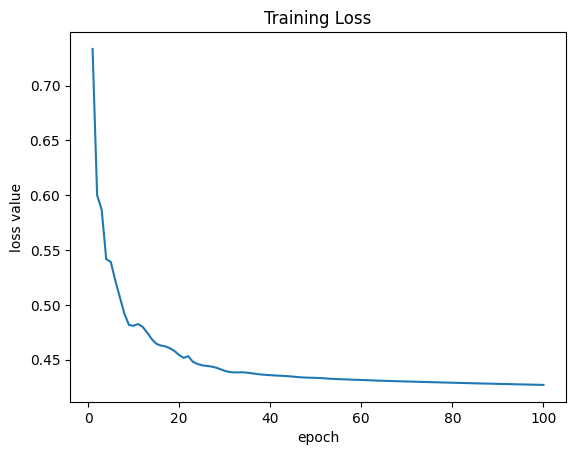

In [10]:
import matplotlib.pyplot as plt

plt.title("Training Loss")
plt.plot(range(1, epochs+1), train_losses)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

隨機採樣friend pairs作為評價調整演算法的基準

In [13]:
future_friend_pairs = sample_friend_pairs(ds, count=count, seed=seed)

定義調整演算法
* RuleBase
* Random Walk with Restart
* Simulated Annealing

In [11]:
method = RandomWalkWithRestart(restart_ratio, max_alter_count, walk_graph, epsilon)

### 測試程式

In [14]:
origin_ranks, new_ranks = [], []

with tqdm(total=count, desc="Total Progress", position=0) as outer_progress:
    for pair in future_friend_pairs:
        src, tgt = pair
        g = method.fit(ds["train_g"], pair)
        
        # change new graph to dataset
        link_prediction_ds.set_new_graph(g)
        # split the dataset before training
        ds = link_prediction_ds.split(test_ratio, pairs=future_friend_pairs)

        # build up pipeline
        torch.manual_seed( seed )
        new_pipeline = Pipeline(model_name, hidden_size, link_prediction_ds.get_feature_size())
        new_pipeline.train(ds, lr, epochs, outer_progress)

        # get new rank
        origin_ranks.append( pipeline.predict_rank(ds["train_g"], src, tgt) )
        new_ranks.append( new_pipeline.predict_rank(ds["train_g"], src, tgt) )
    
# output the score
print( compute_rank_error(origin_ranks, new_ranks) )

Total Progress:  10%|█         | 1/10 [00:04<00:38,  4.24s/it]


AUC: 0.961958


Total Progress:  20%|██        | 2/10 [00:08<00:35,  4.46s/it]


AUC: 0.957674


Total Progress:  30%|███       | 3/10 [00:14<00:33,  4.79s/it]


AUC: 0.951984


Total Progress:  40%|████      | 4/10 [00:18<00:27,  4.58s/it]


AUC: 0.947314


Total Progress:  50%|█████     | 5/10 [00:22<00:22,  4.40s/it]


AUC: 0.939850


Total Progress:  60%|██████    | 6/10 [00:26<00:17,  4.29s/it]


AUC: 0.927306


Total Progress:  70%|███████   | 7/10 [00:30<00:12,  4.20s/it]


AUC: 0.928491


Total Progress:  80%|████████  | 8/10 [00:34<00:08,  4.10s/it]


AUC: 0.917184


Total Progress:  90%|█████████ | 9/10 [00:38<00:04,  4.02s/it]


AUC: 0.915893


Total Progress: 100%|██████████| 10/10 [00:42<00:00,  4.22s/it]


AUC: 0.917524
{'average': 50.7, 'max': 2285, 'min': -1077}
